In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 2.5 MB/s 


In [2]:
from fastai.text.all import *

In [4]:
vax_tweets = pd.read_csv('/content/vaccination_all_tweets.csv')

In [5]:
tweets = pd.read_csv('/content/tweet_dataset.csv')

In [6]:
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
vax_tweets['sentiment'] = np.nan

df_lm = tweets[['text', 'sentiment']].append(vax_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))

268207 31395


In [7]:
df_clas.head()

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,negative


In [8]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)
dls_lm.show_batch(max_n=2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxunk xxmaj ten hours ago , i was was sleeping , sorry . xxbos xxmaj ghana will receive about a million doses of the sputnik - v vaccines soon \n\n xxmaj more xxmaj here : https : / / t.co / xxunk … https : / / t.co / xxmaj xxunk m xxbos xxmaj got my first dose of # xxup covid # vaccine today . # vaccinated \n▁ # xxmaj","xxunk xxmaj ten hours ago , i was was sleeping , sorry . xxbos xxmaj ghana will receive about a million doses of the sputnik - v vaccines soon \n\n xxmaj more xxmaj here : https : / / t.co / xxunk … https : / / t.co / xxmaj xxunk m xxbos xxmaj got my first dose of # xxup covid # vaccine today . # vaccinated \n▁ # xxmaj covaxin"
1,: / / t.co / xxunk xxbos xxmaj just remember that # xxmaj moderna & & # xxmaj pfizer have made their xxup biggest profits w their xxmaj covid vaccine than they ever have in … https : / / t.co / xxunk xxbos xxmaj an 89-year - old man died just days after receiving # xxmaj sinopharm vaccine . xxmaj the vaccinated man was in good health and had … https,/ / t.co / xxunk xxbos xxmaj just remember that # xxmaj moderna & & # xxmaj pfizer have made their xxup biggest profits w their xxmaj covid vaccine than they ever have in … https : / / t.co / xxunk xxbos xxmaj an 89-year - old man died just days after receiving # xxmaj sinopharm vaccine . xxmaj the vaccinated man was in good health and had … https :


In [9]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.0063095735386013985)

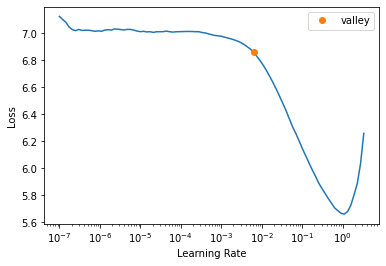

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 6e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.637143,2.562058,0.539763,12.962472,33:40


SuggestedLRs(valley=4.365158383734524e-05)

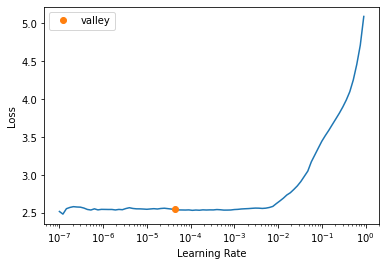

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 3e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.474457,2.518536,0.545189,12.410410,37:34


In [14]:
learn.save_encoder('finetuned_lm')

In [15]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(df_clas, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
dls_clas.show_batch(max=2)

,text,category
0,xxbos xxup pirate xxup voice : xxrep 3 a xxrep 3 r xxrep 3 g xxrep 3 h xxrep 3 ! i 4got xxup my xxup damn xxup wallet xxup at xxup work xxup xxunk xxrep 3 ! xxup dammit xxrep 3 ! xxup so xxup close xxup yet xxup so xxup far xxrep 3 ! xxup now xxup i m xxup starving xxrep 3 !,negative
1,"xxbos xxunk xxrep 3 o a xxrep 3 h ! i kno xxrep 3 w ! i saw it xxmaj may 5th and 6th in xxmaj newcastle and it was so good xxrep 3 ! xxmaj i 'm soo excited for 6th xxmaj june , as its my bday aswell !",positive
2,"xxbos i go to & ' user xxmaj experience xxmaj roundtable xxmaj hamburg - xxmaj xxunk xxmaj fischer on xxmaj accessibility , xxup xxunk xxmaj test & ' https : / / xxrep 3 w xxunk / events / xxrep 3 3 xxunk xxmaj do n't miss !",neutral
3,"xxbos xxunk xxmaj happy xxmaj friday ! xxmaj do u know how i can get a copy of the xxup bt art u did on xxmaj mel 's fake xxmaj twitter ? xxmaj i 'm n it , but ca n't find it now . xxup thx",positive
4,"xxbos xxmaj jamie @ xxmaj sean xxmaj cody , up for some angry sex ? : xxmaj jamie @ xxmaj sean xxmaj cody , i would n't piss this one off xxmaj hey there xxmaj guys , xxmaj do .. http : / / tinyurl.com / xxunk",neutral
5,xxbos @heidimontag xxup wow xxup and xxup to xxup think xxup some xxup people xxup actually xxup really xxup do xxup live xxup in xxup the xxup jungle xxup but xxup do nt xxup get xxup to xxup go xxup back xxup to a xxup hotel .,neutral
6,xxbos afaik a xxup little xxup sad xxup that xxup xxunk xxup is xxup no xxup longer xxup available xxup for xxup xxunk xxup we d xxup nights . xxup bummer xxrep 4 ! xxup xxunk xxup going xxup there xxup we d xxup nights .,negative
7,"xxbos c xxrep 3 o l. - xxmaj weekend xxunk that great , xxrep 3 e h. xxmaj wha xxrep 4 t ever . xxmaj friday was better than i expected it to be , so i … http : / / tumblr.com / xxunk",neutral
8,"xxbos xxunk & ' icant xxup live , i ca nt live xxrep 3 ! & ' lmao . xxmaj oh and btw - xxrep 4 o xxrep 3 w ch my foot hurry with that plaster , i m going to bleed to death",negative


In [17]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [18]:
learn = learn.load_encoder('finetuned_lm')

In [19]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.921052,0.849622,0.605351,01:01


In [20]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.830100,0.730880,0.682433,01:05


In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.702355,0.635982,0.727186,01:17


In [22]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.646290,0.620233,0.743590,01:38
1,0.623502,0.607558,0.747571,01:39
2,0.597105,0.605198,0.751075,01:39


In [23]:
learn.save('classifier')

Path('models/classifier.pth')

In [24]:
pred_dl = dls_clas.test_dl(vax_tweets['text'])

In [25]:
preds = learn.get_preds(dl=pred_dl)

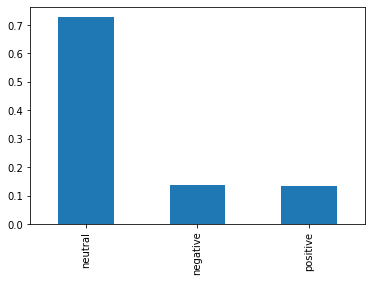

In [26]:
vax_tweets['sentiment'] = preds[0].argmax(dim=-1)
vax_tweets['sentiment'] = vax_tweets['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Convert dates
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date

# Save to csv
vax_tweets.to_csv('vax_tweets_sentiment.csv')

# Plot sentiment value counts
vax_tweets['sentiment'].value_counts(normalize=True).plot.bar();

In [27]:
# Remove today's date since data is incomplete
today = pd.Timestamp.today().date()
vax_tweets = vax_tweets[vax_tweets['date']!=today]

# Get counts of number of tweets by sentiment for each date
timeline = vax_tweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

# Plot results
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [28]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-04-21']
spike['user_location'].value_counts(ascending=False).head(10)

India                             170
New Delhi, India                   90
Toronto, Canada  and Worldwide     74
Mumbai, India                      56
Bengaluru, India                   47
New Delhi                          27
Hyderabad, India                   24
भारत                               23
Mumbai                             19
Chennai                            19
Name: user_location, dtype: int64

In [29]:
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,neutral
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False,neutral
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,neutral
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False,neutral
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,neutral


In [30]:
all_vax = ['johnson', 'covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

johnson = filtered_timeline(vax_tweets, ['johnson', 'J&J', 'JJ'], title='Johnson and Johnson')

In [31]:
moderna = filtered_timeline(vax_tweets, ['moderna'], title="Moderna")

In [32]:
pfizer = filtered_timeline(vax_tweets, ['pfizer'], title='Pfizer')

In [33]:
!pip install wordninja
!pip install pyspellchecker

     |████████████████████████████████| 541 kB 5.2 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=d67e3ce84e10275d19891b2ff2662c4a74d1b45256589be5c929d6bc081868c6
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
     |████████████████████████████████| 2.7 MB 5.2 MB/s 


In [34]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

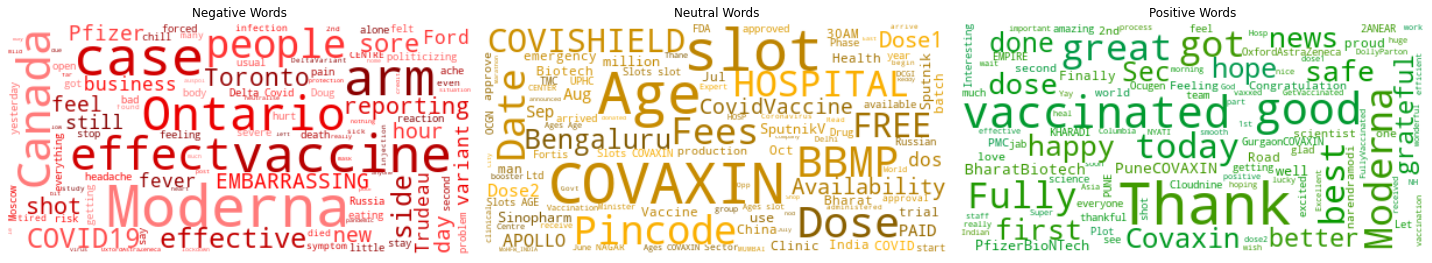

In [36]:
# Convert string to a list of words
vax_tweets['words'] = vax_tweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(vax_tweets)

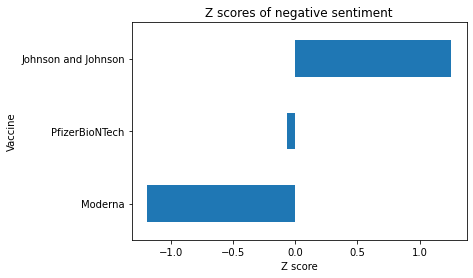

In [38]:
# Get z scores of sentiment for each vaccine
vax_names = {'Moderna': moderna,'PfizerBioNTech': pfizer, 'Johnson and Johnson': johnson}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['negative', 'neutral', 'positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('negative_zscore')['negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

In [ ]:
location_sent = vax_tweets.replace([np.inf, -np.inf], np.nan)

location_sent = location_sent[location_sent['date'] != today]

location_sent.head()